# Determining System Temperature of HERA

In [1]:
import h5py
import numpy as np

from pyuvdata import UVData
import matplotlib.pyplot as plt

import sys
sys.path.append("/users/pkeller/code/H1C_IDR3.2/")

from closurelib import heradata as heradata

## Load Data

In [2]:
vis_path = "/lustre/aoc/projects/hera/pkeller/data/2458105/zen.2458105.25973.IDR2_1.xx.HH.uvOCRS/"
omega_path = "/lustre/aoc/projects/hera/pkeller/HERA-Beams/NicolasFagnoniBeams/Omega_Dipole.dat"


# two antennas and two times
ant1, ant2 = (70, 71)
t1, t2 = (55, 56)

# polarisation
pol = "xx"

# channels
chan_min = 100
chan_max = 900
chans = np.arange(chan_min, chan_max)

# visibility data
UV = UVData()
UV.read(vis_path)
UV.select(freq_chans=chans, polarizations=[pol])

lst = np.unique(UV.lst_array * 12 / np.pi)
freq = UV.freq_array[0]

# (ant1, ant2, pol)
vis = UV.get_data(ant1, ant2, pol)[[t1, t2]]
auto_1 = UV.get_data(ant1, ant1, pol)[[t1, t2]].mean(0)
auto_2 = UV.get_data(ant2, ant2, pol)[[t1, t2]].mean(0)

# read averaged beam area
omega = np.loadtxt(omega_path)[chan_min:chan_max]

# constants
c =  299792458
kb = 1.3806503 * 1e-23

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


In [3]:
root = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/"
fname = "/zen.grp1.of1.LST.*.sum.LPXL.uvh5"

auto_lst_binned_1 = heradata.getDataLST(root, 70, 70, 1.6, fname)
auto_lst_binned_2 = heradata.getDataLST(root, 71, 71, 1.6, fname)

antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


## Functions for Computing $T_\mathrm{sys}$

In [4]:
def Tsys_from_autos(auto1, auto2, freq, omega):
    """
    compute Tsys from auto corralation visibilities
    """   
    return c**2 * np.sqrt(auto1 * auto2) / (2 * kb * freq**2 * omega) * 1e-26


def Tsys_from_diff(vis1, vis2, freq, omega, df, dt, hw=10):
    """
    compute Tsys from differenced visibilities. Compute RMS as a running mean of width 2*hw along frequency.
    """ 
    dvis = (vis1 - vis2) / np.sqrt(2)
    N = len(dvis)
    rms = np.array([np.sqrt(np.mean(np.abs(dvis[max(0, i-hw):min(N, i+hw)])**2)) for i in range(N)])
    
    return c**2 * np.sqrt(df * dt) * rms / (2 * kb * freq**2 * omega) * 1e-26


def sig_from_Tsys(Tsys, freq, omega, df, dt):
    """
    Compute noise standard deviation form Tsys
    """
    return np.sqrt(2) * freq**2 * omega * kb * Tsys / (c**2 * np.sqrt(dt * df)) * 1e26

## Compute $T_\mathrm{sys}$
There seems to be fairly good agreement between $T_\mathrm{sys}$ computed from auto correlations and thos computed from difference visibilities. That computed from LST-binned data seem to be somewhat higher.

In [5]:
Tsys_auto = Tsys_from_autos(auto_1, auto_2, freq, omega)
Tsys_auto_binned = Tsys_from_autos(auto_lst_binned_1[chan_min:chan_max, 0], auto_lst_binned_2[chan_min:chan_max, 0], freq, omega)
Tsys_diff = Tsys_from_diff(vis[0], vis[1], freq, omega, 1e8 / 1024, 10.7)

Casting complex values to real discards the imaginary part


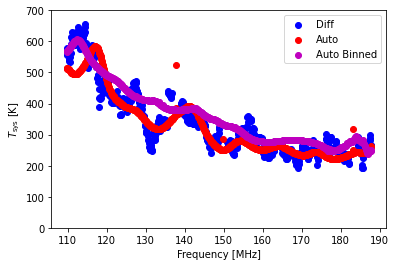

In [6]:
plt.scatter(freq * 1e-6, Tsys_diff, color="b", label="Diff")
plt.scatter(freq * 1e-6, Tsys_auto, color="r", label="Auto")
plt.scatter(freq * 1e-6, Tsys_auto_binned, color="m", label="Auto Binned")

plt.xlabel("Frequency [MHz]")
plt.ylabel(r"$T_\mathrm{sys}$ [K]")
plt.ylim([0, 700])
plt.legend()

## Plot Differenced Visibilities

Casting complex values to real discards the imaginary part


Text(0, 0.5, '$(V_1 - V_2) / \\sqrt{2}$ [Jy]')

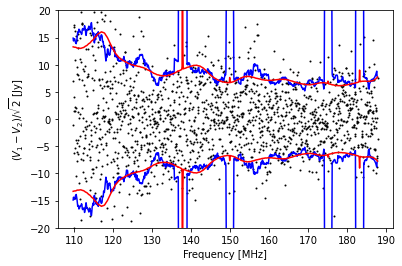

In [7]:
dvis = (vis[0] - vis[1]) / np.sqrt(2)
N = len(dvis)
hw = 10
rms = np.array([np.sqrt(np.mean(np.abs(dvis[max(0, i-hw):min(N, i+hw)])**2)) for i in range(N)])
sig = sig_from_Tsys(Tsys_auto, freq, omega, 1e8 / 1024, 10.7) * np.sqrt(2)

plt.scatter(freq*1e-6, dvis.real, s=1, color="k")
plt.scatter(freq*1e-6, dvis.imag, s=1, color="k")

plt.plot(freq*1e-6, rms, color="b")
plt.plot(freq*1e-6, -rms, color="b")
plt.plot(freq*1e-6, sig, color="r")
plt.plot(freq*1e-6, -sig, color="r")
plt.ylim([-20, 20])
plt.xlabel("Frequency [MHz]")
plt.ylabel(r"$(V_1 - V_2) / \sqrt{2}$ [Jy]")